## 1. Import Libraries

In [197]:
import numpy as np
import pandas as pd

import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import string
import textstat
from ftfy import fix_text
from num2words import num2words

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')

!python -m spacy download en_core_web_md
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\thinc\compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "ha

     -------------------------------------- 42.8/42.8 MB 638.5 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


C:\Users\User\AppData\Roaming\Python\Python39\site-packages\thinc\compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]
2023-11-10 16:59:53.991140: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-11-10 16:59:53.991606: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-10 16:59:58.266282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-11-10 16:59:58.269609: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2023-11-10 16:59:58.272820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Coul

In [198]:
# load provided job postings
dataset_path = "../Raw Data Files/fake_job_postings.csv"
dataset = pd.read_csv(dataset_path)
dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [199]:
# load generated and scraped job postings
df_fraud_generated = pd.read_csv('../Scraping/Fake Data//cf_fakejobs.csv')
df_nofraud_scraped = pd.read_csv('../Scraping/CareersFuture/cleaned_data_nonfraud.csv')

df_fraud_generated['fraudulent'] = 1
df_nofraud_scraped['fraudulent'] = 0

dataset_cf = pd.concat([df_fraud_generated, df_nofraud_scraped], ignore_index=True)

dataset_cf.head()

,job_post_id,title,address,department,salary_range,company_profile,description,requirement,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,min_experience,company,industry,salary_type,fraudulent
0,MCF-2023-03021,Senior Project Manager,"50 Raffles Place, #15-01, Singapore Land Tower...",Project Management,12000-15000,Global Solutions Ltd. is a leading project man...,As a Senior Project Manager at Global Solution...,10+ years of project management experience,Competitive salary and bonus,0,0,1,Full-time,Mid-Level,8,Global Solutions Ltd.,Project Management,Monthly,1
1,MCF-2023-03022,Legal Counsel,"6 Battery Road, #20-01, Singapore 049909",Legal,15000-18000,LegalEase Partners is a reputable law firm pro...,LegalEase Partners is looking for a Legal Coun...,Law degree and bar admission,Healthcare and dental coverage,0,1,1,Full-time,Director,4,LegalEase Partners,Legal Services,Monthly,1
2,MCF-2023-03023,Data Analyst (Contract),"3 Church Street, Samsung Hub, Singapore 049483",Data Analysis,6000-8000,TechData Analytics is a data-driven company se...,Join TechData Analytics as a Data Analyst (Con...,Experience in data analysis preferred,Contract-based role,0,1,1,Contract,Senior Level,5,TechData Analytics,Data Analytics,Monthly,1
3,MCF-2023-03024,Marketing Director,"1 Raffles Quay, North Tower, Singapore 048583",Marketing,18000-22000,MaxiMedia Group is a marketing agency speciali...,MaxiMedia Group is in search of a Marketing Di...,10+ years of marketing experience,Performance-based bonuses,0,0,0,Full-time,Senior Level,2,MaxiMedia Group,Marketing,Monthly,1
4,MCF-2023-03025,UX/UI Designer,"9 Temasek Boulevard, #04-02, Suntec Tower Two,...",Design,8000-10000,DesignMasters Co. is a design studio dedicated...,DesignMasters Co. is hiring a UX/UI Designer t...,Strong portfolio of design work,Flexible work hours,0,0,1,Full-time,Senior Level,0,DesignMasters Co.,Design,Monthly,1


In [200]:
# clean generated and scraped job postings
dataset_cf['location'] = np.where(dataset_cf['address'].notna(), 'SG', '')
dataset_cf.rename(columns={'requirement': 'requirements', 'job_post_id': 'job_id'}, inplace=True)
del dataset_cf['address'], dataset_cf['company'], dataset_cf['industry'], dataset_cf['salary_type'], dataset_cf['min_experience']
dataset_cf.head()


,job_id,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,fraudulent,location
0,MCF-2023-03021,Senior Project Manager,Project Management,12000-15000,Global Solutions Ltd. is a leading project man...,As a Senior Project Manager at Global Solution...,10+ years of project management experience,Competitive salary and bonus,0,0,1,Full-time,Mid-Level,1,SG
1,MCF-2023-03022,Legal Counsel,Legal,15000-18000,LegalEase Partners is a reputable law firm pro...,LegalEase Partners is looking for a Legal Coun...,Law degree and bar admission,Healthcare and dental coverage,0,1,1,Full-time,Director,1,SG
2,MCF-2023-03023,Data Analyst (Contract),Data Analysis,6000-8000,TechData Analytics is a data-driven company se...,Join TechData Analytics as a Data Analyst (Con...,Experience in data analysis preferred,Contract-based role,0,1,1,Contract,Senior Level,1,SG
3,MCF-2023-03024,Marketing Director,Marketing,18000-22000,MaxiMedia Group is a marketing agency speciali...,MaxiMedia Group is in search of a Marketing Di...,10+ years of marketing experience,Performance-based bonuses,0,0,0,Full-time,Senior Level,1,SG
4,MCF-2023-03025,UX/UI Designer,Design,8000-10000,DesignMasters Co. is a design studio dedicated...,DesignMasters Co. is hiring a UX/UI Designer t...,Strong portfolio of design work,Flexible work hours,0,0,1,Full-time,Senior Level,1,SG


In [201]:
# combine all job postings
dataset = pd.concat([dataset, dataset_cf], ignore_index=True)
dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## 2. Basic Understanding of the Data

In [202]:
print(dataset.shape)
dataset.info()

(25996, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25996 entries, 0 to 25995
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               25996 non-null  object
 1   title                25996 non-null  object
 2   location             25650 non-null  object
 3   department           14449 non-null  object
 4   salary_range         10979 non-null  object
 5   company_profile      22688 non-null  object
 6   description          25742 non-null  object
 7   requirements         17067 non-null  object
 8   benefits             11361 non-null  object
 9   telecommuting        25996 non-null  int64 
 10  has_company_logo     25996 non-null  int64 
 11  has_questions        25996 non-null  int64 
 12  employment_type      22525 non-null  object
 13  required_experience  18912 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  obje

In [203]:
dataset.duplicated().sum()

0

In [204]:
dataset.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15017
company_profile         3308
description              254
requirements            8929
benefits               14635
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7084
required_education     16221
industry               13019
function               14571
fraudulent                 0
dtype: int64

<AxesSubplot:>

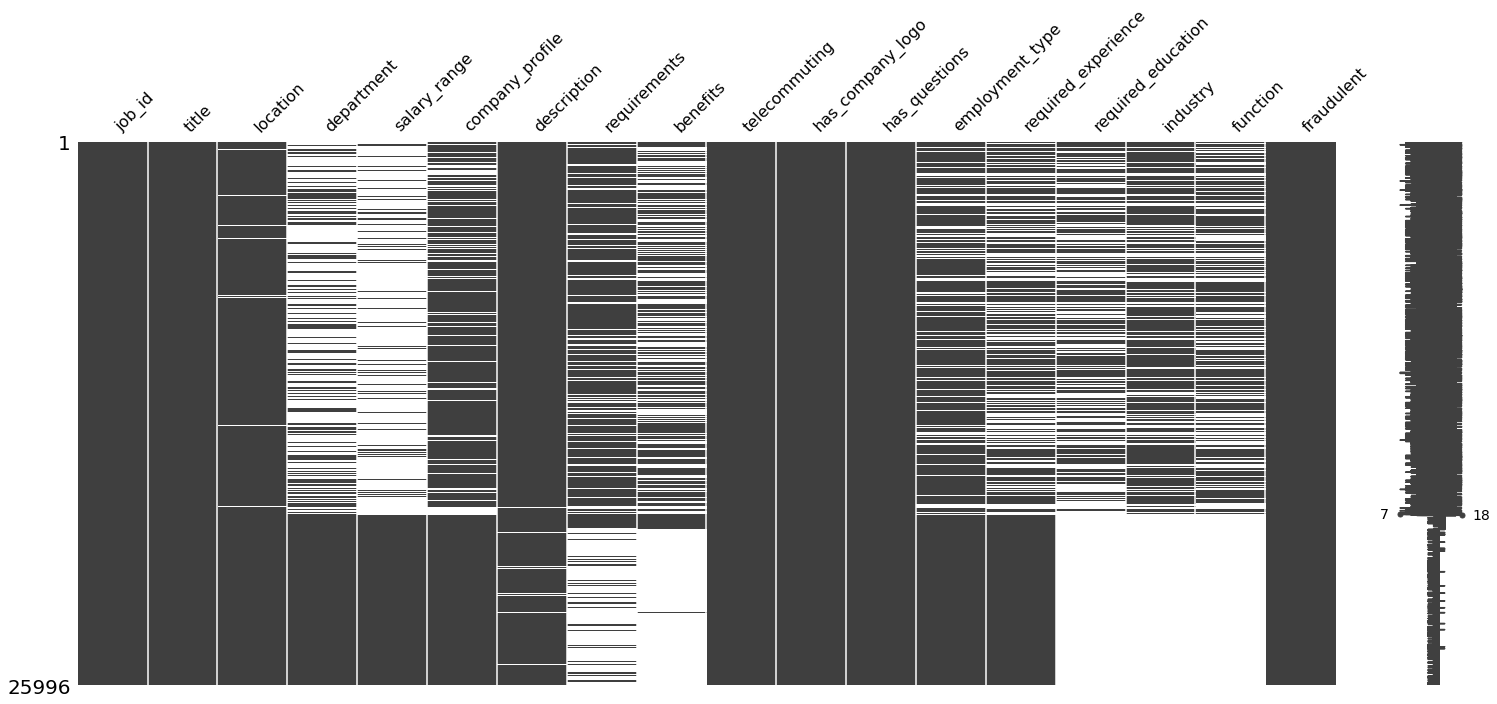

In [205]:
# Alternative way to have a quick glance to check missing values
missingno.matrix(dataset)

From the data, we understand that there are 0 duplicated rows, but alot of missing values, especially for department and salary range in the originally provided dataset. Other columns to note are employment_type, required_experience, required_education, industry, function, requirements and benefits. We will dive deep to understand each of this data column better to try and account for the missing values.

## 2. Feature Engineering

### 2.1 Location > Country

In [206]:
dataset['location_country'] = dataset['location'].str.split(',').str[0].str.strip()
dataset[['location_country']] = dataset[['location_country']].applymap(lambda x: x if x else np.NaN)
dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,location_country
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [207]:
dataset['location_country'].value_counts(dropna=False).head(10)

US     10656
SG      5230
NaN     3312
GB      2384
GR       940
CA       457
DE       383
NZ       333
IN       276
AU       214
Name: location_country, dtype: int64

### 2.2 Title, Company Profile, Description, Requirements, Benefits, Category > Full Text

In [208]:
# Combine the 5 columns into a column called full_text
dataset['title'] = dataset['title'].fillna('').str.strip()
dataset['company_profile'] = dataset['company_profile'].fillna('').str.strip()
dataset['description'] = dataset['description'].fillna('').str.strip()
dataset['requirements'] = dataset['requirements'].fillna('').str.strip()
dataset['benefits'] = dataset['benefits'].fillna('').str.strip()

dataset['title_contain_urgent'] = dataset['title'].apply(lambda x: 1 if 'urgent' in x.lower() else 0)
dataset['have_company_profile'] = np.where(dataset['company_profile'] == '', 0, 1)
dataset['have_description'] = np.where(dataset['description'] == '', 0, 1)
dataset['have_requirements'] = np.where(dataset['requirements'] == '', 0, 1)
dataset['have_benefits'] = np.where(dataset['benefits'] == '', 0, 1)

dataset['full_text'] = dataset['title'] + ' ' + dataset['company_profile'] + ' ' + dataset['description'] + ' ' + dataset['requirements'] + ' ' + dataset['benefits']

dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,location_country,title_contain_urgent,have_company_profile,have_description,have_requirements,have_benefits,full_text
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US,0,1,1,1,0,"Marketing Intern We're Food52, and we've creat..."
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,0,1,1,1,1,Customer Service - Cloud Video Production 90 S...
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US,0,1,1,1,0,Commissioning Machinery Assistant (CMA) Valor ...
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,0,1,1,1,1,Account Executive - Washington DC Our passion ...
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,0,1,1,1,1,Bill Review Manager SpotSource Solutions LLC i...


### 2.3 Industry, Department, Function > Category > Full Text

In [209]:
# fill in missing values with the help of key words from 'title'
# str_list = ['Engineer','Account','Accountant','Accounting','Developer','Sales','Marketing','Beauty','Service','Customer','Consumer',
# 'Customer','Writer','Pet','Architect', 'Dog', 'Game', 'Mobile', 'Design', 'Financial','Programmer']
# for strs in str_list:
#   dataset.loc[(dataset['title'].str.contains(strs, case=False, na=False)) & (dataset['department'].isna()),'department'] = \
#   dataset[dataset['title'].str.contains(strs, case=False, na=False)]['department'].mode()[0]
#   dataset.loc[(dataset['title'].str.contains(strs, case=False, na=False)) & (dataset['industry'].isna()),'industry'] = \
#   dataset[dataset['title'].str.contains(strs, case=False, na=False)]['industry'].mode()[0]
#   dataset.loc[(dataset['title'].str.contains(strs, case=False, na=False)) & (dataset['function'].isna()),'function'] = \
#   dataset[dataset['title'].str.contains(strs, case=False, na=False)]['function'].mode()[0]

# clean category column
# punctuations = string.punctuation
# stop_words = spacy.lang.en.stop_words.STOP_WORDS
# nlp = spacy.load("en_core_web_md")
# def transform(text):
#     tokens = nlp(text.lower())
#     tokens = list(set(tokens)) # remove duplicates before processing
#     tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word for word in tokens]
#     tokens = [word for word in tokens if word not in stop_words and word not in punctuations]
#     tokens = list(set(tokens)) # remove duplicates after processing
#     tokens.sort() # order words by a standard format so categories with same words can be grouped together
#     output = " ".join(tokens)
#     output = re.sub('\s{2,}', " ", output).strip()
#     return output
# dataset['category'] = dataset['category'].map(transform)
# dataset[['category']] = dataset[['category']].map(lambda x: 'unspecified' if x == '' else x)

In [210]:
# combine into 'category'
dataset['industry'] = dataset['industry'].fillna('').str.strip()
dataset['department'] = dataset['department'].fillna('').str.strip()
dataset['function'] = dataset['function'].fillna('').str.strip()
dataset['category'] = (dataset['industry'] + ' ' + dataset['department'] + ' ' + dataset['function']).str.strip()

In [211]:
# combine into 'full_text'
dataset['have_category'] = np.where(dataset['category'] == '', 0, 1)
                           
dataset['full_text'] = dataset['full_text'] + ' ' + dataset['category']

dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,location_country,title_contain_urgent,have_company_profile,have_description,have_requirements,have_benefits,full_text,category,have_category
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,NaN,,Marketing,0,US,0,1,1,1,0,"Marketing Intern We're Food52, and we've creat...",Marketing Marketing,1
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,0,1,1,1,1,Customer Service - Cloud Video Production 90 S...,Marketing and Advertising Success Customer Ser...,1
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,NaN,NaN,NaN,,,0,US,0,1,1,1,0,Commissioning Machinery Assistant (CMA) Valor ...,,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,0,1,1,1,1,Account Executive - Washington DC Our passion ...,Computer Software Sales Sales,1
4,5,Bill Review Manager,"US, FL, Fort Worth",,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,0,1,1,1,1,Bill Review Manager SpotSource Solutions LLC i...,Hospital & Health Care Health Care Provider,1


In [212]:
fraud_text = dataset[dataset.fraudulent == 1].full_text
nofraud_text = dataset[dataset.fraudulent == 0].full_text

print("##### Fraud #####")
print(fraud_text.value_counts(dropna=False),"\n")

print("##### No Fraud #####")
print(nofraud_text.value_counts(dropna=False))

##### Fraud #####
Home Based Payroll Typist/Data Entry Clerks Positions Available  We have several openings available in this area earning $1000.00-$2500.00 per week. We are seeking only honest, self-motivated people with a desire to work in the home typing and data entry field, from the comfort of their own homes.The preferred applicants should be at least 18 years old with Internet access. No experience is needed. However the following skills are desirable: Basic computer and typing skills, ability to spell and print neatly, ability to follow directions. All you need is access to the Internet and you can participate. This is an entry level position and we offer full online training. You do NOT need any special skills to get started.Earn as much as you can from the comfort of your home typing and doing data entry.  Complete Training provided before you start working and it’s easy to start!  ________________________________________Don’t let this opportunity pass you by.POSITIONS ARE ST

In [213]:
# STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
# plt.figure(figsize = (16,8))
# wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(fraud_text)))
# plt.imshow(wc,interpolation = 'bilinear')

In [214]:
# STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
# plt.figure(figsize = (16,8))
# wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(nofraud_text)))
# plt.imshow(wc,interpolation = 'bilinear')

### 2.4 Identify High Salary

In [215]:
def check_high_salary(text):
    lower_text = text.lower()
    high_pay_keywords = [
        'high paid', 'high pay', 'highly paid', 'high-paid', 
        'competitive salary', 'above-average pay', 'attractive compensation', 
        'generous wage', 'lucrative package', 'top compensation', 
        'excellent pay', 'premium salary', 'significant earnings',
        'well-paid', 'top-tier compensation', 'premium wages',
        'exceptional salary', 'competitive remuneration', 'attractive wage'
    ]
    
    for keyword in high_pay_keywords:
        if keyword in lower_text:
            return 1
    
    return 0

dataset['high_salary'] = dataset['full_text'].apply(check_high_salary)

dataset['high_salary'].value_counts(dropna=False)

0    23828
1     2168
Name: high_salary, dtype: int64

### 2.5 Full Text Readability

In [216]:
dataset['ft_flesch_score'] = dataset['full_text'].apply(textstat.flesch_reading_ease) # low score = very confusing
dataset['ft_fk_grade_level'] = dataset['full_text'].apply(textstat.flesch_kincaid_grade)

# # flesch score binning
# def map_to_flesch_score(score):
#     if score >= 90:
#         return "Very Easy"
#     elif 80 <= score <= 89:
#         return "Easy"
#     elif 70 <= score <= 79:
#         return "Fairly Easy"
#     elif 60 <= score <= 69:
#         return "Standard"
#     elif 50 <= score <= 59:
#         return "Fairly Difficult"
#     elif 30 <= score <= 49:
#         return "Difficult"
#     else:
#         return "Very Difficult"
    
# # grade level binning 
# def map_to_fk_grade_level(score):
#     if score >= 18:
#         return "Advanced"
#     elif 12 <= score <= 17:
#         return "Skilled"
#     elif 6 <= score <= 11:
#         return "Average"
#     elif 0 <= score <= 5:
#         return "Basic"
#     else:
#         return "Beginner"
    
# flesch score binning manual label encoding
def map_to_flesch_score(score):
    if score >= 90:
        return "1"
    elif 80 <= score <= 89:
        return "2"
    elif 70 <= score <= 79:
        return "3"
    elif 60 <= score <= 69:
        return "4"
    elif 50 <= score <= 59:
        return "5"
    elif 30 <= score <= 49:
        return "6"
    else:
        return "7"
    
# grade level binning manual label encoding
def map_to_fk_grade_level(score):
    if score >= 18:
        return "1"
    elif 12 <= score <= 17:
        return "2"
    elif 6 <= score <= 11:
        return "3"
    elif 0 <= score <= 5:
        return "4"
    else:
        return "5"
    
dataset['flesch_score_bin_ft'] = dataset['ft_flesch_score'].apply(map_to_flesch_score)
dataset['fk_grade_level_bin_ft'] = dataset['ft_fk_grade_level'].apply(map_to_fk_grade_level)

del dataset['ft_flesch_score']
del dataset['ft_fk_grade_level']

print(dataset['flesch_score_bin_ft'].value_counts(dropna=False),"\n")
print(dataset['fk_grade_level_bin_ft'].value_counts(dropna=False))

7    14993
6     8855
5     1519
4      499
3      103
2       17
1       10
Name: flesch_score_bin_ft, dtype: int64 

2    13144
1     6072
3     3446
5     3294
4       40
Name: fk_grade_level_bin_ft, dtype: int64


## 3. Data Cleaning

### 3.1 Handle Missing Values

In [217]:
dataset.isna().sum()

job_id                       0
title                        0
location                   346
department                   0
salary_range             15017
company_profile              0
description                  0
requirements                 0
benefits                     0
telecommuting                0
has_company_logo             0
has_questions                0
employment_type           3471
required_experience       7084
required_education       16221
industry                     0
function                     0
fraudulent                   0
location_country          3312
title_contain_urgent         0
have_company_profile         0
have_description             0
have_requirements            0
have_benefits                0
full_text                    0
category                     0
have_category                0
high_salary                  0
flesch_score_bin_ft          0
fk_grade_level_bin_ft        0
dtype: int64

#### 3.1.1 Salary Range 

We will drop the Salary Range as there are too many missing values. 

In [218]:
del dataset['salary_range']

#### 3.1.2 Location

We will only keep country information. Missing values are filled with 'unspecfied'.

In [219]:
del dataset['location']
dataset['location_country'] = dataset['location_country'].fillna('unspecified')

#### 3.1.3 employment type, required_education, required_experience

In [220]:
dataset['check_text'] = dataset['title'] + ' ' + dataset['description'] + ' ' + dataset['requirements']
# try to use these text data to impute missing values

##### employment type

In [221]:
dataset.employment_type.value_counts(dropna=False)

Full-time                                                 11651
NaN                                                        3471
Full Time                                                  2957
Contract                                                   2186
Permanent, Full Time                                       2170
                                                          ...  
Temporary, Contract, Flexi-work                               1
Temporary, Contract, Part Time, Freelance, Full Time          1
Contract, Freelance, Flexi-work, Internship/Attachment        1
Temporary, Internship/Attachment                              1
Contract, Part Time, Flexi-work, Internship/Attachment        1
Name: employment_type, Length: 104, dtype: int64

In [222]:
# Convert all words in the "employment_type" column to lowercase
dataset['employment_type'] = dataset['employment_type'].str.lower()

# Remove hyphens from the "employment_type" column
dataset['employment_type'] = dataset['employment_type'].str.replace('-', ' ')
dataset['employment_type'] = dataset['employment_type'].str.replace('_', ' ')
dataset['employment_type'] = dataset['employment_type'].str.replace('/', ' ')
dataset['employment_type'] = dataset['employment_type'].str.replace(',', ' ')

In [223]:
employment_types_to_check = ['full time', 'contract', 'part time', 'temporary', 'other', 'flexi', 'internship']

def fill_employment_type(row):
    if pd.isna(row['employment_type']):
        result = ''
        count = 0
        title_modified = row['check_text'].replace(r'[-_/,\s]+', ' ').lower()
        for employment_type in employment_types_to_check:
            if employment_type in title_modified:
                if count == 0:
                    result = employment_type
                    count += 1
                else:
                    result = 'flexi'
        if count > 0:
            return result

    return row['employment_type']

dataset['employment_type'] = dataset.apply(fill_employment_type, axis=1)

In [224]:
def get_main_type(value):
    if pd.notna(value):  # Check if the value is not NaN
        result = 'other'
        count = 0
        for employment_type in employment_types_to_check:
            if employment_type in value:
                if count == 0:
                    result = employment_type
                    count += 1
                else:
                    result = 'flexi'
        return result
    else:
        return 'unspecified'  # Handle NaN values

dataset['employment_type'] = dataset['employment_type'].apply(get_main_type)

In [225]:
dataset['employment_type'] = dataset['employment_type'].replace('internship', 'temporary')
dataset['employment_type'] = dataset['employment_type'].replace('temporary', 'contract')

In [226]:
dataset.employment_type.value_counts(dropna=False)

full time      16944
contract        3007
other           1998
unspecified     1594
flexi           1413
part time       1040
Name: employment_type, dtype: int64

##### required experience

In [227]:
dataset.required_experience.value_counts(dropna=False)

NaN                                        7084
Mid-Senior level                           3832
Entry level                                2701
Associate                                  2297
Executive                                  1867
                                           ... 
Fashion styling certification preferred       1
10+ years operations management exp           1
Ph.D. in Biomedical Sciences                  1
5+ years UX research leadership               1
Manager, Executive                            1
Name: required_experience, Length: 92, dtype: int64

In [228]:
dataset['required_experience'] = dataset['required_experience'].str.lower()
dataset['required_experience'] = dataset['required_experience'].str.replace('/', ' ')
dataset['required_experience'] = dataset['required_experience'].str.replace(',', ' ')
dataset['required_experience'] = dataset['required_experience'].str.replace('+', ' ')
dataset['required_experience'] = dataset['required_experience'].str.replace('-', ' ')
dataset['required_experience'] = dataset['required_experience'].str.replace('.', '')

In [229]:
required_experience_to_check = ['junior', 'fresh', 'entry', 'internship', 'associate', 'senior', 'professional', 'manage',
                                'experienced', 'leadership', 'expert', 'executive', 'director', 'mid', 'middle']

def fill_required_experience(row):
    if pd.isna(row['required_experience']):
        for required_experience in required_experience_to_check:
            if required_experience in row['check_text'].replace(r'[-_/,\s]+', ' ').lower():
                return required_experience
    return row['required_experience']

dataset['required_experience'] = dataset.apply(fill_required_experience, axis=1)

In [230]:
def categorize_experience(value):
    if isinstance(value, str):
        # Extract numerical values from the string using regular expressions
        years = [int(x) for x in re.findall(r'\d+', value)]  # Extract all numeric values as a list
        if years:
            # Calculate the mean of the extracted years
            mean_years = sum(years) / len(years)
            if mean_years <= 10:
                return 'junior'
            elif mean_years <= 19:
                return 'middle'
            else:
                return 'senior'
    return value

# Apply the function to the 'required_experience' column
dataset['required_experience'] = dataset['required_experience'].apply(categorize_experience)

In [231]:
entry_level_keywords = ['junior', 'fresh', 'entry', 'internship', 'associate']

def categorize_value(value):
    if isinstance(value, str):
        for keyword in entry_level_keywords:
            if keyword in value:
                return 'entry level'
    return value

dataset['required_experience'] = dataset['required_experience'].apply(categorize_value)

In [232]:
middle_level_keywords = ['mid', 'middle']

def categorize_value(value):
    if isinstance(value, str):
        for keyword in middle_level_keywords:
            if keyword in value.lower():
                return 'middle level'
    return value

dataset['required_experience'] = dataset['required_experience'].apply(categorize_value)

In [233]:
senior_level_keywords = ['senior', 'professional', 'manage', 'experienced', 'leadership', 'expert', 'executive', 'director']

def categorize_value(value):
    if isinstance(value, str):
        for keyword in senior_level_keywords:
            if keyword in value.lower():
                return 'senior level'
    return value

dataset['required_experience'] = dataset['required_experience'].apply(categorize_value)

In [234]:
def categorize_experience(value):
    if value in ['middle level', 'senior level', 'entry level']:
        return value
    elif not value or value in ['not applicable','']:
        return 'unspecified'
    else:
        return 'entry level'

# Apply the categorization function to the 'required_experience' column
dataset['required_experience'] = dataset['required_experience'].apply(categorize_experience)

In [235]:
dataset.required_experience.value_counts(dropna=False)

entry level     11107
senior level     9561
middle level     4212
unspecified      1116
Name: required_experience, dtype: int64

##### required education

In [236]:
dataset.required_education.value_counts(dropna=False)

NaN                                  16221
Bachelor's Degree                     5145
High School or equivalent             2080
Unspecified                           1397
Master's Degree                        416
Associate Degree                       274
Certification                          170
Some College Coursework Completed      102
Professional                            74
Vocational                              49
Some High School Coursework             27
Doctorate                               26
Vocational - HS Diploma                  9
Vocational - Degree                      6
Name: required_education, dtype: int64

In [237]:
dataset['required_education'] = dataset['required_education'].str.lower()
dataset['required_education'] = dataset['required_education'].str.replace('/', ' ')
dataset['required_education'] = dataset['required_education'].str.replace(',', ' ')
dataset['required_education'] = dataset['required_education'].str.replace('+', ' ')
dataset['required_education'] = dataset['required_education'].str.replace('-', ' ')
dataset['required_education'] = dataset['required_education'].str.replace('.', '')

In [238]:
# NaN from 16221 to 13096

required_education_to_check = ['bachelor', 'high school', 'master', 'phd', 'doctorate',
                               'associate degree', 'vocational', 'undergraduate', 'graduate', 'postgraduate', 'tertiary']

def fill_required_education(row):
    if pd.isna(row['required_education']):
        for required_education in required_education_to_check:
            if required_education in row['check_text'].replace(r'[-_/,\s]+', ' ').lower():
                return required_education

    return row['required_education']

dataset['required_education'] = dataset.apply(fill_required_education, axis=1)

In [239]:
def group_education(value):
    if pd.isna(value):
        return 'unspecified'
    elif 'high school' in value or 'hs diploma' in value or 'vocational' in value:
        return 'high school or vocational degree'
    elif 'bachelor' in value or 'associate degree' in value or 'tertiary' in value or 'undergraduate' in value:
        return 'undergraduate'
    elif 'master' in value or 'graduate' in value or 'postgraduate' in value or 'phd' in value or 'professional' in value or 'Doctorate' in value:
        return 'graduate'
    else:
        return 'unspecified'


# Apply the updated grouping function to the 'required_education' column
dataset['required_education'] = dataset['required_education'].apply(group_education)

In [240]:
dataset.required_education.value_counts(dropna=False)

unspecified                         14794
undergraduate                        7203
high school or vocational degree     2569
graduate                             1430
Name: required_education, dtype: int64

#### 3.1.4 Drop Useless Columns

In [242]:
drop_cols = ['job_id','title','company_profile','description','requirements','benefits','department','industry','function','category','check_text']
dataset = dataset.drop(drop_cols,axis=1)
dataset.isna().sum()

telecommuting            0
has_company_logo         0
has_questions            0
employment_type          0
required_experience      0
required_education       0
fraudulent               0
location_country         0
title_contain_urgent     0
have_company_profile     0
have_description         0
have_requirements        0
have_benefits            0
full_text                0
have_category            0
high_salary              0
flesch_score_bin_ft      0
fk_grade_level_bin_ft    0
dtype: int64

### 3.2 Drop Columns with Low Variance

In [243]:
# Filter numeric columns only
numeric_columns = dataset.select_dtypes(include="number")

# Calculate the variance for numeric columns
variance_info = numeric_columns.var()

# Display the variance for each numeric column
print(variance_info)

telecommuting           0.050956
has_company_logo        0.126009
has_questions           0.232130
fraudulent              0.055461
title_contain_urgent    0.002953
have_company_profile    0.111062
have_description        0.009713
have_requirements       0.225533
have_benefits           0.246005
have_category           0.095144
high_salary             0.076445
dtype: float64


In [244]:
del dataset['have_description']
del dataset['title_contain_urgent']

### 3.3 Clean Text Data

In [245]:
def normalise_text(text,remove_stop_words=True):
    text = fix_text(text)
    text = text.lower() # lowercase
    text = text.replace("'","").replace("’","") # remove apostrophes ("can't">"cant")
    text = re.sub('#\S+#', " ", text) # removes #URL_...# #PHONE_...# #EMAIL_...# #*_...#
    text = re.sub('\xa0', " ", text) # remove \xa0
    text = re.sub('<.*?>'," ",text) # remove <> tags
    text = re.sub('#\S+', " ", text) # replaces hashtags
    text = re.sub('@\S+', " ", text)  # remove mentions
    text = re.sub("http\S+", " ", text) # remove URL addresses starting with http
    text = re.sub('www\S+', " ", text) # remove URL addresses starting with www
    text = re.sub('\d+', lambda x: ' '+num2words(x.group(), to='cardinal')+' ', text) # convert numbers to words ('food52'>'food fifty-two ')
    text = re.sub("[^a-zA-Z]", " ", text) # letters only
    text = re.sub('\s{2,}', " ", text).strip() # replace more than or equal to two white spaces into one white space
    if remove_stop_words:
      stop_words = set(nltk.corpus.stopwords.words('english'))
      text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    # if stem_words:
    # stemmer = PorterStemmer()
    # text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
    return text

In [246]:
dataset['full_text'] = dataset['full_text'].apply(lambda x: normalise_text(x))
dataset['text_len'] = dataset['full_text'].apply(lambda x: len(x.split(' ')))
dataset.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,fraudulent,location_country,have_company_profile,have_requirements,have_benefits,full_text,have_category,high_salary,flesch_score_bin_ft,fk_grade_level_bin_ft,text_len
0,0,1,0,other,entry level,unspecified,0,US,1,1,0,marketing intern food fifty two weve created g...,1,0,7,1,269
1,0,1,0,full time,unspecified,unspecified,0,NZ,1,1,1,customer service cloud video production ninety...,1,0,6,2,572
2,0,1,0,contract,senior level,unspecified,0,US,1,1,0,commissioning machinery assistant cma valor se...,0,0,7,2,235
3,0,1,0,full time,middle level,undergraduate,0,US,1,1,1,account executive washington dc passion improv...,1,0,7,1,501
4,0,1,1,full time,middle level,undergraduate,0,US,1,1,1,bill review manager spotsource solutions llc g...,1,0,7,1,376


In [247]:
# check duplicates
dataset.duplicated().sum()

2071

In [311]:
# drop duplicates
dataset = dataset.drop_duplicates()

In [312]:
# save to an output file
dataset.to_csv('../Raw Data Files/final_job_posting.csv', index=False)